<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

# Описание и цель проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# План проекта

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Выгрузка данных, преобразование дат в нужны тип, установка индексации по дате.
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=0)

In [3]:
# Проверка на то, что данные расположены в хронологическом порядке
print(df.index.is_monotonic)

True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Произведем ресемплирование по одному часу
df = df.resample('1H').sum()

Данные выгружены, столбец содержащий даты преобразован в соответствующий тип и установлен в качестве индекса для всего датасета.
Данные за период с 1 марта 2018 по 31 августа 2018 года, расположены в хронологическом порядке.
Всего имеем 26496 Строк.
Пропуски отсутсвуют.

Загрузка и предобработка данных выполнена.

## Анализ

<AxesSubplot:xlabel='datetime'>

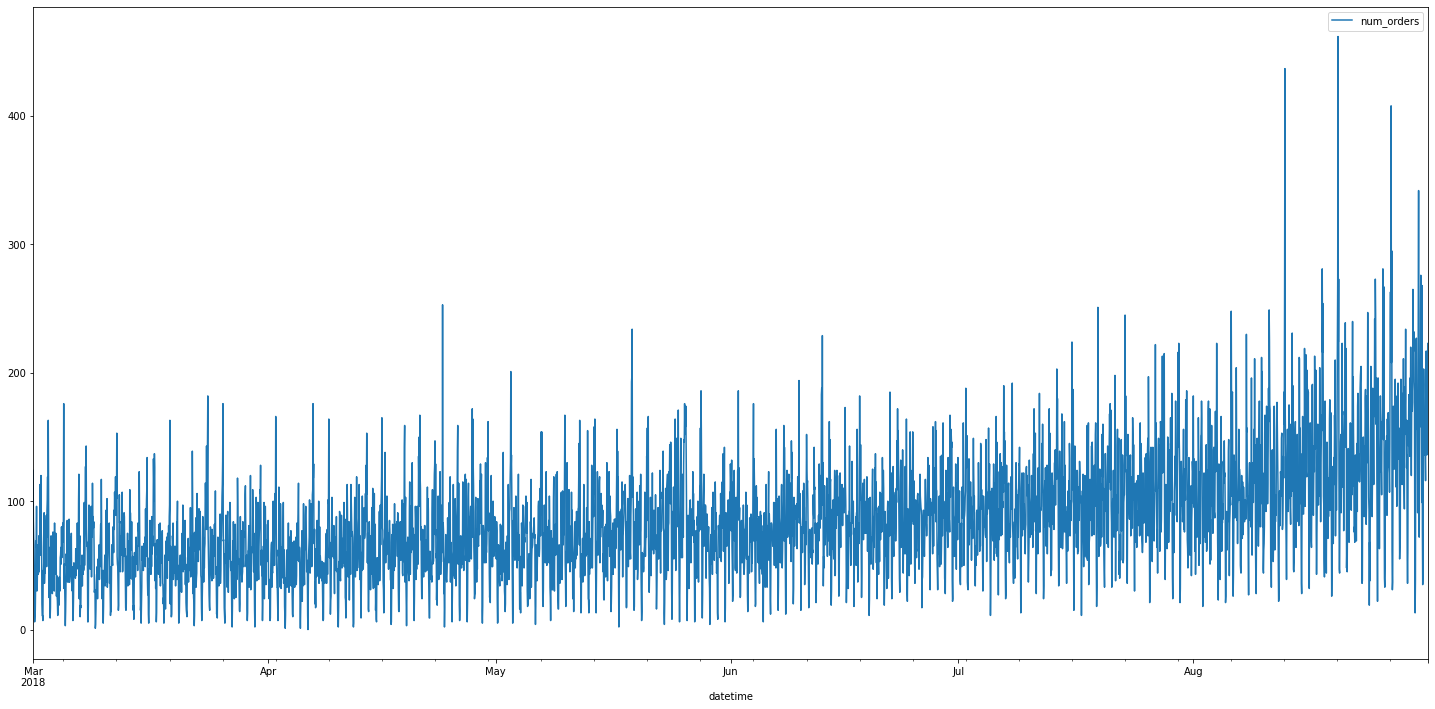

In [6]:
# Построим график
df.plot(figsize=(25,12))

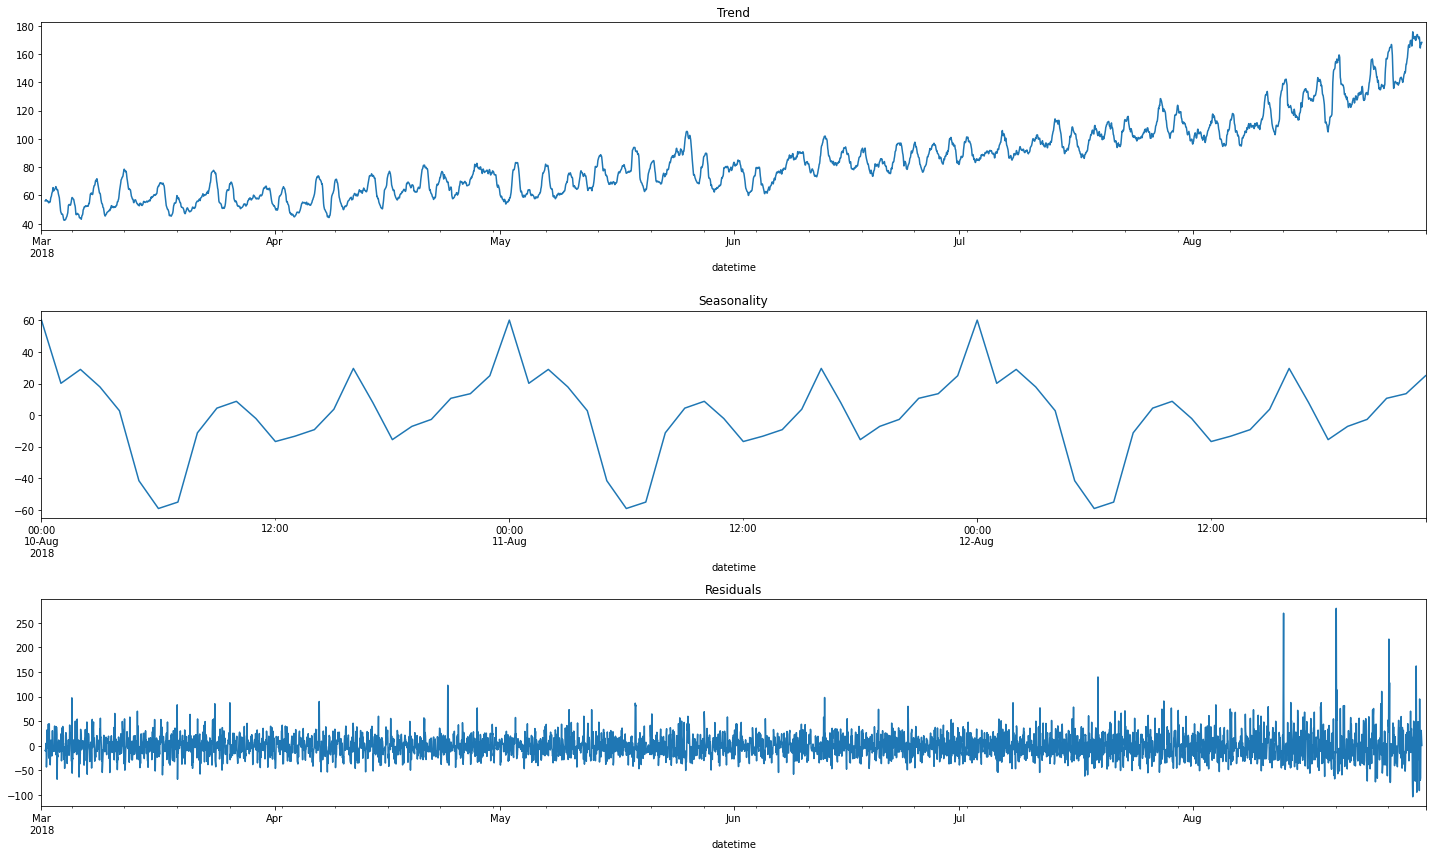

In [7]:
# Разложим временной ряд на тренд и сезонную компоненту. Выведем графики.
decomposed = seasonal_decompose(df)

plt.figure(figsize=(20,12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
#decomposed.seasonal['2018-08-10':'2018-08-17'].plot(ax=plt.gca())
decomposed.seasonal['2018-08-10':'2018-08-12'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

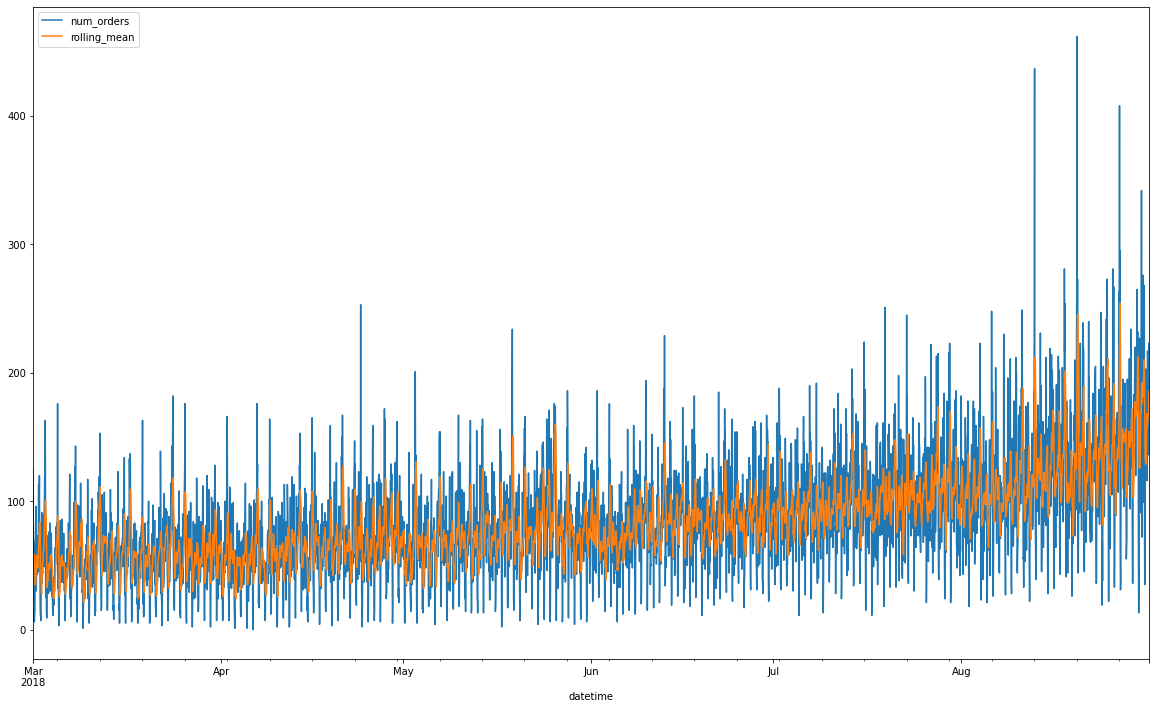

In [8]:
# Введем в датасет среднее скользящее
df['rolling_mean'] = df.rolling(7).mean() 
df.plot(figsize=(20,12))

По данным графикам, можно сделать вывод, что среднее количество заявок растет с течением времени. Так же наблюдается сезонность в течении суток, пик количества заявок приходится на полночь.

Еще можно сделать вывод, что временной ряд не стационарный, потому что у него меняется среднее значение.

## Обучение

In [9]:
# Создадим признаки на основе столбца с датой
def sign(data, lags, roll):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    
    for lag in range(1, lags + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(roll).mean()

sign(df, 24, 48)
df = df.dropna()
display(df.head())

,num_orders,rolling_mean,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,59.791667,3,3,5,72.0,119.0,101.0,93.0,49.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0
2018-03-03 01:00:00,108,60.604167,3,3,5,163.0,72.0,119.0,101.0,93.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0
2018-03-03 02:00:00,25,61.083333,3,3,5,108.0,163.0,72.0,119.0,101.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0
2018-03-03 03:00:00,64,60.125000,3,3,5,25.0,108.0,163.0,72.0,119.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0
2018-03-03 04:00:00,44,60.083333,3,3,5,64.0,25.0,108.0,163.0,72.0,...,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0


In [10]:
RND = 12345
tscv = TimeSeriesSplit(n_splits=12)

features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

# Создадим тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                              test_size=0.1, shuffle=False, random_state=RND)

### Дерево решений

In [11]:
grid_space = {'max_depth':[1,3,4,5,6,7,8,9,10]}

# Найдем оптимальные значения гиперпараметров и обучим модель
model = DecisionTreeRegressor(random_state = RND)
decision_tree = GridSearchCV(model, param_grid = grid_space, scoring='neg_mean_squared_error', cv=tscv)
decision_tree_v = decision_tree.fit(features_train, target_train)

# Выведим лучшее значение метрики и при каких гиперпараметрах оно было получено
print('Оптимальное значение гиперпараметров:', decision_tree_v.best_params_)
print('Лучший показатель RMSE: {:.2f}'.format((-decision_tree_v.best_score_) ** 0.5))

Оптимальное значение гиперпараметров: {'max_depth': 5}
Лучший показатель RMSE: 29.76


### LightGBM

In [13]:
grid_space = {
    'max_depth': [11],
    'learning_rate': [0.1],
    'cat_smooth': [1]
}

# Найдем оптимальные значения гиперпараметров и обучим модель
model = LGBMRegressor(random_state = RND)
lgbm_reg = GridSearchCV(model, param_grid = grid_space, scoring='neg_mean_squared_error', cv=tscv)
lgbm_reg_v = lgbm_reg.fit(features_train, target_train)

# Выведим лучшее значение метрики и при каких гиперпараметрах оно было получено
print('Оптимальное значение гиперпараметров:', lgbm_reg_v.best_params_)
print('Лучший показатель RMSE: {:.2f}'.format((-lgbm_reg_v.best_score_) ** 0.5))

### CatBoostRegressor 

In [14]:
# После подбора значений в сетке остались только лучшие, для уменьшения времени загрузки проекта
grid_space = {
            'n_estimators' : [150],
            'verbose' : [0],
            'max_depth' : [7]
}

# Найдем оптимальные значения гиперпараметров и обучим модель
model = CatBoostRegressor(random_state = RND)
cat_boost = GridSearchCV(model, param_grid = grid_space, scoring='neg_mean_squared_error', cv=tscv)
cat_boost_v = cat_boost.fit(features_train, target_train)

# Выведим лучшее значение метрики и при каких гиперпараметрах оно было получено
print('Оптимальное значение гиперпараметров:', cat_boost_v.best_params_)
print('Лучший показатель RMSE: {:.2f}'.format((-cat_boost_v.best_score_) ** 0.5))

Оптимальное значение гиперпараметров: {'max_depth': 7, 'n_estimators': 150, 'verbose': 0}
Лучший показатель RMSE: 24.34


Из трех использованных моделей, получены следующие показатели:


* Дерево решений, значение RMSE: 29.76

 При значениях гиперпараметров: 'max_depth': 5
 
 

* LightGBM, значение RMSE: 24.78

 При значения гиперпараметров: 'cat_smooth': 1, 'learning_rate': 0.1, 'max_depth': 11
 
 

* CatBoostRegressor, значение RMSE: 24.34

 При значение гиперпараметров: 'max_depth': 7, 'n_estimators': 150, 'verbose': 0

Таким образом лучшее значение оказалось у LightGBM. Проверим ее качество на тестовой выборке.

## Тестирование

In [15]:
prediction = cat_boost.predict(features_test)
metric_test = mean_squared_error(target_test, prediction, squared=False)
metric_test

43.17602875544651

Значение заявленной метрики RMSE: 43.17 у CatBoostRegressor на тестовой выборке.

Это удовлетворяет условию поставленной задачи, оптимальная модель найдена.

# Вывод

В ходе выполнения проекта:
* Данные были загружены и изучены. 
* Столбец со значением даты преобразован в соответствующий тип и задан как индекс для всего датафрейма.
* Произведена проверка на отсутствие пропусков и хронологичность данных. Пропуски отсутствуют, данные * расположены в хронологическом порядке.
* Произведено ресемплирование по одному часу.
* Для анализа данных, были построены графики показывающие тренд и сезонности, а так же график с плавающим средним. Выявился общий восходящий тренд за весь период и сезонность в течении суток, наибольшее количество заявок в ночное время. Кроме того, так как среднее значение меняется, можно сделать вывод что временной ряд не стационарный.
* Для дальнейшего обучения добавлены признаки на основе значения стобца с датами. 
* Данные разделены на тренировочную и тестовую выборку.
* Проведено обучение моделей Дерево решений, LightGBM и CatBoostRegressor с замерами метрики RMSE. Все модели показали реузльтат удовлетворяющий условиям задачи (RMSE не выше 48). 
* Выбрана модель с лучшим показателем RMSE CatBoostRegressor (24.34), для работы на тестовой выборке. Показатель RMSE удовлетворительный - 43.17.


Оптимальная модель удовлетворяющая всем условиям поставленной задчи найдена. Это CatBoostRegressor.
